# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline
import re
from pandas.io.json import json_normalize
import seaborn as sns
from timeit import default_timer as timer
import datetime

from sklearn.metrics import confusion_matrix, f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration and Cleaning

Let's take a look through the dataframes we are working with for the project and clean the data as we go.

In [3]:
# porfolio contains information about the 10 offers send to users.
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


We should create a unique column for each channel to be able to use that information later on.

In [4]:
# create a new column for each channel
portfolio['channel_web'],  portfolio['channel_email'], portfolio['channel_mobile'], portfolio['channel_social']= 0, 0, 0, 0



In [5]:
# Label the data by iterating over the list data for each offer
for i, row in portfolio.iterrows():
    if 'web' in portfolio.channels[i]:
        portfolio['channel_web'][i] = 1
    if 'email' in portfolio.channels[i]:
        portfolio['channel_email'][i] = 1
    if 'mobile' in portfolio.channels[i]:
        portfolio['channel_mobile'][i] = 1
    if 'social' in portfolio.channels[i]:
        portfolio['channel_social'][i] = 1
    


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is tryin

In [6]:
# we can now drop the channels column
portfolio.drop('channels', axis=1, inplace=True)

In [7]:
# add a new column that tracks the duration in hours as it is currently in days
portfolio['duration_hours'] = portfolio['duration'] * 24

In [8]:
# let's add a unique id for each offer to help us track them across dataframes.
# I grabbed this code from the previous udacity IBM recommendation project
def offer_mapper():
    coded_dict = dict()
    cter = 1
    offer_id_encoded = []
    
    for val in portfolio['id']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        offer_id_encoded.append(coded_dict[val])
    return offer_id_encoded

offer_id_encoded = offer_mapper()
portfolio['offer_id'] = offer_id_encoded

In [9]:
# Let's check the changes to the dataframe
portfolio

,difficulty,duration,id,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social,duration_hours,offer_id
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,168,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,120,2
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0,96,3
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0,168,4
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0,240,5
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,168,6
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,240,7
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1,72,8
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,120,9
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0,168,10


In [10]:
# Let's take a look at the profile dataframe
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [11]:
profile.gender.value_counts(), profile.shape

(M    8484
 F    6129
 O     212
 Name: gender, dtype: int64, (17000, 5))

In [12]:
# Let's take a look at the missing data from the profile dataframe
profile.gender.isna().value_counts(), profile.income.isna().value_counts()

(False    14825
 True      2175
 Name: gender, dtype: int64, False    14825
 True      2175
 Name: income, dtype: int64)

2175 users don't have age, gender or income data.

In [13]:
# convert became_member_on from an int to a datetime object
# create a new column days_a_member which is the max date in the dataset
# subtracted by date the user joined
date_joined = []
for i in profile.became_member_on.index:
    date_joined.append(datetime.datetime.strptime(str(profile.became_member_on.loc[i]), '%Y%m%d').date())

profile['date_member'] = date_joined

profile['days_a_member'] = (profile['date_member'].max() - profile['date_member']).dt.days
profile.drop('became_member_on', axis=1, inplace = True)

In [14]:
# Create user_ids for each user in the profile dataframe
def id_mapper():
    coded_dict = dict()
    cter = 1
    id_encoded = []
    
    for val in profile['id']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        id_encoded.append(coded_dict[val])
    return id_encoded

id_encoded = id_mapper()
profile['user_id'] = id_encoded

# show header
profile.head()

,age,gender,id,income,date_member,days_a_member,user_id
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12,529,1
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,376,2
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018-07-12,14,3
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,443,4
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017-08-04,356,5


In [15]:
transcript.shape

(306534, 4)

In [16]:
# Let's look at the transcript dataframe
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [17]:
# How many of each type of event is in the transcript dataframe
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [18]:
# Create new dataframe that joins the transcript to the profile, 
# so we can get demographic information about the events
df = transcript.join(profile.set_index('id'), on='person')
df.shape

(306534, 10)

In [19]:
df.head()

,event,person,time,value,age,gender,income,date_member,days_a_member,user_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75,F,100000.0,2017-05-09,443,4
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},118,None,NaN,2017-08-04,356,5
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},68,M,70000.0,2018-04-26,91,6
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},118,None,NaN,2017-09-25,304,7
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},118,None,NaN,2017-10-02,297,8


We need to extract the information from the dict values in the value column. 

In [20]:
# use json_normalize to get event data and create a new data frame 
# which contains the offer id which we need to use to join the portfolio dataframe
offers = json_normalize(df['value'])

In [21]:
offers.head()

,amount,offer id,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [22]:
# join the offers dataframe to the main event + demographics df dataframe
df = df.join(offers, how='outer')

In [23]:
# Create a column that combines the offer ids 
# different offer event had different offer id labels ('offer id' and 'offer_id').
df['offer_id'] = df.offer_id.combine_first(df['offer id'])

In [24]:
# drop the offer id column as all the offer ids are now in the offer_id columns
df.drop(['offer id', 'value', 'person'], axis=1, inplace=True)

In [25]:
df.head()

,event,time,age,gender,income,date_member,days_a_member,user_id,amount,offer_id,reward
0,offer received,0,75,F,100000.0,2017-05-09,443,4,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,0,118,None,NaN,2017-08-04,356,5,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,0,68,M,70000.0,2018-04-26,91,6,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,0,118,None,NaN,2017-09-25,304,7,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,0,118,None,NaN,2017-10-02,297,8,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [26]:
#Let's take a quick look at the amounts spent and rewards earned across this dataset
user_rewards_earned = df.groupby('user_id')['reward'].sum().sort_values(ascending=False)
user_amount_spent = df.groupby('user_id')['amount'].sum().sort_values(ascending=False)

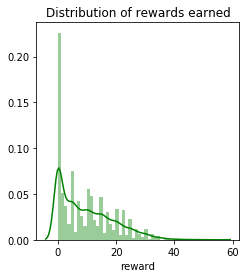

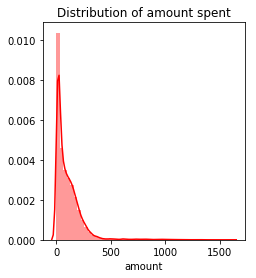

In [27]:
# plot distribution of amount spent or reward earned across the users in the dataframe
plt.figure(figsize=(8,4))
plt.subplot(121)
sns.distplot(user_rewards_earned, color='green');
plt.title('Distribution of rewards earned')
plt.figure(figsize=(8,4))
plt.subplot(122)
sns.distplot(user_amount_spent,  color='red');
plt.title('Distribution of amount spent')
plt.show()

In [28]:
# Lets look at the profile stats
profile.describe()

,age,income,days_a_member,user_id
count,17000.000000,14825.000000,17000.000000,17000.000000
mean,62.531412,65404.991568,517.449882,8500.500000
std,26.738580,21598.299410,411.223904,4907.621624
min,18.000000,30000.000000,0.000000,1.000000
25%,45.000000,49000.000000,208.000000,4250.750000
50%,58.000000,64000.000000,358.000000,8500.500000
75%,73.000000,80000.000000,791.000000,12750.250000
max,118.000000,120000.000000,1823.000000,17000.000000


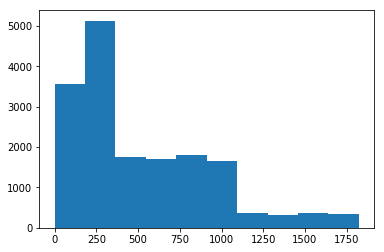

In [29]:
# Plot how many days the user has been a member
plt.hist(profile['days_a_member']);

Both distributions of the amount spent and rewards earned are right skewed.

We need to create categorical columns for the age ranges and income ranges to be able to chart the differences of order completions across groups.

In [30]:
age_range = []
for a in profile.age:
    if a == 118:
        age_range.append(np.nan)
    elif a >= 18 and a <=24:
        age_range.append('18-24')
    elif a >= 25 and a <=34:
        age_range.append('25-34')
    elif a >= 35 and a <=44:
        age_range.append('35-44')
    elif a >= 45 and a <=54:
        age_range.append('45-54')
    elif a >= 55 and a <=64:
        age_range.append('55-64')
    elif a >= 65 and a <=74:
        age_range.append('65-74')
    elif a >= 75 and a < 117:
        age_range.append('75+')

age_range_df = []
for a in df.age:
    if a == 118:
        age_range_df.append(np.nan)
    elif a >= 18 and a <=24:
        age_range_df.append('18-24')
    elif a >= 25 and a <=34:
        age_range_df.append('25-34')
    elif a >= 35 and a <=44:
        age_range_df.append('35-44')
    elif a >= 45 and a <=54:
        age_range_df.append('45-54')
    elif a >= 55 and a <=64:
        age_range_df.append('55-64')
    elif a >= 65 and a <=74:
        age_range_df.append('65-74')
    elif a >= 75 and a < 117:
        age_range_df.append('75+')
len(age_range_df), len(df.age)
        
len(age_range), len(profile.age)

(17000, 17000)

In [31]:
p_income_range = []
for i in profile.income:
    if i >=30000 and i <49000:
        p_income_range.append('30k-49k')
    elif i >=49000 and i <64000:
        p_income_range.append('49k-64k')
    elif i >=64000 and i <80000:
        p_income_range.append('64k-80k')
    elif i >=80000 and i <120000:
        p_income_range.append('80k-120k')
    else:
        p_income_range.append(np.nan)
print(len(p_income_range), len(profile.income))
        
df_income_range = []
for i in df.income:
    if i >=30000 and i <49000:
        df_income_range.append('30k-49k')
    elif i >=49000 and i <64000:
        df_income_range.append('49k-64k')
    elif i >=64000 and i <80000:
        df_income_range.append('64k-80k')
    elif i >=80000 and i <120000:
        df_income_range.append('80k-120k')
    else:
        df_income_range.append(np.nan)

17000 17000


In [32]:
# create columns in each dataframe for the age range and income range
profile['age_range'] = age_range
df['age_range'] = age_range_df
profile['income_range'] = p_income_range
df['income_range'] = df_income_range


In [33]:
# Replace age 118 with nan value
profile.age.replace(118, np.nan, inplace=True)
df.age.replace(118, np.nan, inplace=True)

In [34]:
# input nan in gender columns
df.gender.fillna(value=pd.np.nan, inplace=True)
profile.gender.fillna(value=pd.np.nan, inplace=True)

In [35]:
df.head()

,event,time,age,gender,income,date_member,days_a_member,user_id,amount,offer_id,reward,age_range,income_range
0,offer received,0,75.0,F,100000.0,2017-05-09,443,4,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75+,80k-120k
1,offer received,0,NaN,NaN,NaN,2017-08-04,356,5,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,0,68.0,M,70000.0,2018-04-26,91,6,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,65-74,64k-80k
3,offer received,0,NaN,NaN,NaN,2017-09-25,304,7,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,0,NaN,NaN,NaN,2017-10-02,297,8,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [36]:
# combine portfolio with the master dataframe
df = df.merge(portfolio, how='left', left_on='offer_id', right_on='id')

In [37]:
# We can drop value, offer id and person columns from the master dataframe df
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 24 columns):
event             306534 non-null object
time              306534 non-null int64
age               272762 non-null float64
gender            272762 non-null object
income            272762 non-null float64
date_member       306534 non-null object
days_a_member     306534 non-null int64
user_id           306534 non-null int64
amount            138953 non-null float64
offer_id_x        167581 non-null object
reward_x          33579 non-null float64
age_range         272762 non-null object
income_range      272529 non-null object
difficulty        167581 non-null float64
duration          167581 non-null float64
id                167581 non-null object
offer_type        167581 non-null object
reward_y          167581 non-null float64
channel_web       167581 non-null float64
channel_email     167581 non-null float64
channel_mobile    167581 non-null float64
channel_social    1675

In [38]:
# let's take a quick look at the number of offers completed across the two offer types
offer_completed = df.query('event == "offer completed"')

In [39]:
# Take a rough look at the number of offers completed 
# from the two offers types we can get this information for at the moment (bogo and discount)
offer_completed.offer_type.value_counts()

discount    17910
bogo        15669
Name: offer_type, dtype: int64

In [40]:
# Calculate the total amount spent and the total rewards earned
reward_sum = offer_completed.reward_x.sum()
transaction = df.query('event == "transaction"')
transaction_sum = round(transaction.amount.sum(), 2)

print("The total amount spent is ${}. \nThe total rewards earned is ${}. \nThe total amount minus rewards is ${}.".format(transaction_sum, reward_sum, transaction_sum-reward_sum))


The total amount spent is $1775451.97. 
The total rewards earned is $164676.0. 
The total amount minus rewards is $1610775.97.


In [41]:
# Let's clean the data to remove any user with NaN values for age, gender or income.
df_clean = df[~df.age.isna()]

In [42]:
df_clean.describe()

,time,age,income,days_a_member,user_id,amount,reward_x,difficulty,duration,reward_y,channel_web,channel_email,channel_mobile,channel_social,duration_hours,offer_id_y
count,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,123957.000000,32444.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.0,148805.000000,148805.000000,148805.000000,148805.000000
mean,366.707694,53.840696,64337.000755,581.291950,8498.072737,13.996325,4.948249,7.890561,6.625207,4.442445,0.806747,1.0,0.917160,0.658311,159.004980,5.545936
std,200.359087,17.551337,21243.762941,428.810204,4893.892626,31.749420,2.905376,5.041335,2.133035,3.372362,0.394851,0.0,0.275641,0.474277,51.192852,2.888141
min,0.000000,18.000000,30000.000000,0.000000,2.000000,0.050000,2.000000,0.000000,3.000000,0.000000,0.000000,1.0,0.000000,0.000000,72.000000,1.000000
25%,186.000000,41.000000,48000.000000,242.000000,4281.000000,3.660000,2.000000,5.000000,5.000000,2.000000,1.000000,1.0,1.000000,0.000000,120.000000,3.000000
50%,408.000000,55.000000,62000.000000,471.000000,8488.000000,10.800000,5.000000,10.000000,7.000000,5.000000,1.000000,1.0,1.000000,1.000000,168.000000,6.000000
75%,528.000000,66.000000,78000.000000,862.000000,12722.000000,19.130000,5.000000,10.000000,7.000000,5.000000,1.000000,1.0,1.000000,1.000000,168.000000,8.000000
max,714.000000,101.000000,120000.000000,1823.000000,17000.000000,1062.280000,10.000000,20.000000,10.000000,10.000000,1.000000,1.0,1.000000,1.000000,240.000000,10.000000


In [43]:
df.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [44]:
df_clean.gender.value_counts()


M    155690
F    113101
O      3971
Name: gender, dtype: int64

In [45]:
amount_spent_age = pd.DataFrame(df_clean.groupby(['age_range'])['amount'].sum())
amount_spent_income = pd.DataFrame(df_clean.groupby('income_range')['amount'].sum())

reward_earned_age = pd.DataFrame(df_clean.groupby(['age_range'])['reward_x'].sum())
reward_earned_income = pd.DataFrame(df_clean.groupby('income_range')['reward_x'].sum())
reward_earned_income.reward_x/amount_spent_income.amount,reward_earned_age.reward_x/amount_spent_age.amount 

(income_range
 30k-49k     0.109003
 49k-64k     0.104614
 64k-80k     0.091421
 80k-120k    0.080501
 dtype: float64, age_range
 18-24    0.092443
 25-34    0.098441
 35-44    0.092451
 45-54    0.096112
 55-64    0.091948
 65-74    0.089017
 75+      0.090120
 dtype: float64)

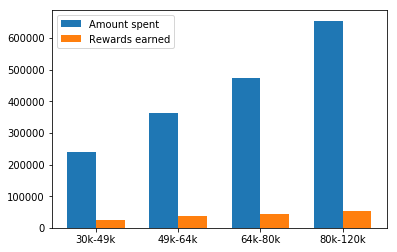

In [46]:
ind = np.arange(len(amount_spent_income.amount))  # the x locations for the groups
width = 0.35
fig, ax = plt.subplots();
rects1 = ax.bar(ind - width/2, amount_spent_income.amount, width,
                label='Amount spent')
rects2 = ax.bar(ind + width/2, reward_earned_income.reward_x, width,
                label='Rewards earned')

ax.set_ylabel('')
ax.set_title('')
ax.set_xticks(ind)
ax.set_xticklabels(amount_spent_income.index)
ax.legend();

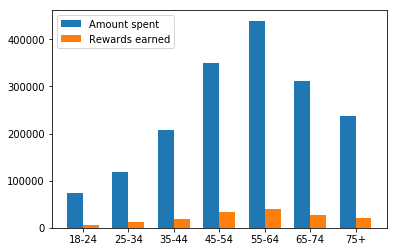

In [47]:
ind = np.arange(len(amount_spent_age.amount))  # the x locations for the groups
width = 0.35
fig, ax = plt.subplots();
rects1 = ax.bar(ind - width/2, amount_spent_age.amount, width,
                label='Amount spent')
rects2 = ax.bar(ind + width/2, reward_earned_age.reward_x, width,
                label='Rewards earned')

ax.set_ylabel('')
ax.set_title('')
ax.set_xticks(ind)
ax.set_xticklabels(amount_spent_age.index)
ax.legend();

### Let's take a quick look at the distribution of the number of offers received by users.

In [48]:
# look at the value_counts per user
num_offers_received = df.groupby(['user_id'])['offer_id_y'].count().sort_values(ascending=False)
num_offers_received.value_counts()

10    2074
8     2069
9     2041
11    1843
12    1664
7     1430
6     1215
13    1181
14    1058
5      657
15     615
4      340
16     311
17     219
3      151
2       63
18      59
0        6
1        4
Name: offer_id_y, dtype: int64

Text(0,0.5,'Number of users')

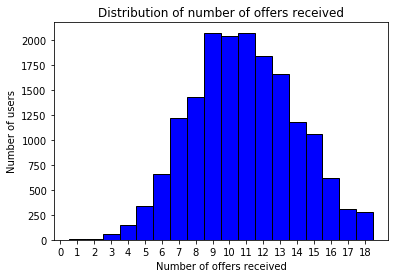

In [49]:
# plot distribution of number of offers received by users
bins=19
plt.hist(num_offers_received, color='blue', bins=range(19), align='right', edgecolor="k");
plt.xticks(np.arange(19))
plt.title('Distribution of number of offers received')
plt.xlabel('Number of offers received');
plt.ylabel('Number of users')

###### It looks like a pretty normal distribution with the majority of users receiving 6 to 13 offers.

In [50]:
df.query('event == "offer received"').groupby(['offer_id_y'])['user_id'].count()

offer_id_y
1.0     7658
2.0     7593
3.0     7617
4.0     7677
5.0     7668
6.0     7646
7.0     7597
8.0     7618
9.0     7571
10.0    7632
Name: user_id, dtype: int64

In [51]:
df.query('event == "offer viewed"').groupby(['offer_id_y'])['user_id'].count()

offer_id_y
1.0     6716
2.0     7298
3.0     4144
4.0     4171
5.0     2663
6.0     7337
7.0     7327
8.0     6687
9.0     7264
10.0    4118
Name: user_id, dtype: int64

In [52]:
df.query('event == "offer completed"').groupby(['offer_id_y'])['user_id'].count()

offer_id_y
1.0     3688
2.0     3331
4.0     4354
5.0     3420
6.0     5156
7.0     5317
9.0     4296
10.0    4017
Name: user_id, dtype: int64

We will have to figure out how to track offer completions only if the offer was viewed as we can see above there are instances where the offer completion rates are greater than the view rates.

In [53]:
df.head()

,event,time,age,gender,income,date_member,days_a_member,user_id,amount,offer_id_x,...,duration,id,offer_type,reward_y,channel_web,channel_email,channel_mobile,channel_social,duration_hours,offer_id_y
0,offer received,0,75.0,F,100000.0,2017-05-09,443,4,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,1.0,1.0,1.0,0.0,168.0,4.0
1,offer received,0,NaN,NaN,NaN,2017-08-04,356,5,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,10.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5.0,1.0,1.0,0.0,0.0,240.0,5.0
2,offer received,0,68.0,M,70000.0,2018-04-26,91,6,NaN,2906b810c7d4411798c6938adc9daaa5,...,7.0,2906b810c7d4411798c6938adc9daaa5,discount,2.0,1.0,1.0,1.0,0.0,168.0,10.0
3,offer received,0,NaN,NaN,NaN,2017-09-25,304,7,NaN,fafdcd668e3743c1bb461111dcafc2a4,...,10.0,fafdcd668e3743c1bb461111dcafc2a4,discount,2.0,1.0,1.0,1.0,1.0,240.0,7.0
4,offer received,0,NaN,NaN,NaN,2017-10-02,297,8,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,...,5.0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10.0,1.0,1.0,1.0,1.0,120.0,2.0


In [54]:
days_member_range = []
for i in profile.days_a_member:
    if i >=0 and i < 242:
        days_member_range.append('0-242_days')
    elif i >=242 and i <471:
        days_member_range.append('242-471_days')
    elif i >=471 and i < 862:
        days_member_range.append('471-862_days')
    elif i >=862 and i < 1823:
        days_member_range.append('862-1823_days')
    else:
        days_member_range.append(np.nan)

        
df_days_member_range = []
for i in df_clean.days_a_member:
    if i >= 0 and i < 242:
        df_days_member_range.append('0-242_days')
    elif i >= 242 and i < 471:
        df_days_member_range.append('242-471_days')
    elif i >= 471 and i < 862:
        df_days_member_range.append('471-862_days')
    elif i >= 862 and i < 1823:
        df_days_member_range.append('862-1823_days')
    else:
        df_days_member_range.append(np.nan)

In [55]:
profile['days_a_member_range'] = days_member_range
df_clean['days_a_member_range'] = df_days_member_range

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [56]:
df_clean.describe()

,time,age,income,days_a_member,user_id,amount,reward_x,difficulty,duration,reward_y,channel_web,channel_email,channel_mobile,channel_social,duration_hours,offer_id_y
count,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,123957.000000,32444.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.0,148805.000000,148805.000000,148805.000000,148805.000000
mean,366.707694,53.840696,64337.000755,581.291950,8498.072737,13.996325,4.948249,7.890561,6.625207,4.442445,0.806747,1.0,0.917160,0.658311,159.004980,5.545936
std,200.359087,17.551337,21243.762941,428.810204,4893.892626,31.749420,2.905376,5.041335,2.133035,3.372362,0.394851,0.0,0.275641,0.474277,51.192852,2.888141
min,0.000000,18.000000,30000.000000,0.000000,2.000000,0.050000,2.000000,0.000000,3.000000,0.000000,0.000000,1.0,0.000000,0.000000,72.000000,1.000000
25%,186.000000,41.000000,48000.000000,242.000000,4281.000000,3.660000,2.000000,5.000000,5.000000,2.000000,1.000000,1.0,1.000000,0.000000,120.000000,3.000000
50%,408.000000,55.000000,62000.000000,471.000000,8488.000000,10.800000,5.000000,10.000000,7.000000,5.000000,1.000000,1.0,1.000000,1.000000,168.000000,6.000000
75%,528.000000,66.000000,78000.000000,862.000000,12722.000000,19.130000,5.000000,10.000000,7.000000,5.000000,1.000000,1.0,1.000000,1.000000,168.000000,8.000000
max,714.000000,101.000000,120000.000000,1823.000000,17000.000000,1062.280000,10.000000,20.000000,10.000000,10.000000,1.000000,1.0,1.000000,1.000000,240.000000,10.000000


## Tracking offer completions

I need to create a function that tracks when an offer is received and if it is viewed before the offer is completed.

I will need to also track offer completions for informational offers by tracking if there are transactions after the offer is viewed and before the offer end time.

I need to add a check to see when offer received and determine from that time whether an offer was completed (not by the viewed time for both functions). 

I need to make sure the offer was viewed prior to the transaction in order to count the transactions. So time from received and after a viewed time.

I will track all offer completions in one set of functions to track true offer completion rates to understand what the key elements are for understanding offer completion rates and develop a set of heuristics. For the model predictions I will create a dataset for each offer id that labels users as a 1 for ever having completing the offer after viewing it and a 0 for users who viewed the offer but did not complete the offer.  

In [120]:
def info_offer_completions(user_id, df=df_clean, offer_id=3):
    '''
    inputs:
    user_id = id of user to see if they have completed the offer
    offer_id = which offer to use to see if an offer was completed
    
    outpus:
    user_offers_completed = int of how many offers were completed for that offer id
    '''
    start = timer()
    user_df = df[df.user_id==user_id]
    offer_df = user_df[user_df.offer_id_y==offer_id]
    
    trans = user_df[user_df.event=='transaction']
    
    user_offers_completed = []

    offer_received = len(offer_df[offer_df.event=='offer received'].index)
    offer_received_idx = offer_df[offer_df.event=='offer viewed'].index
    info_viewed = len(offer_df[offer_df.event=='offer viewed'].index)
    info_viewed_idx = offer_df[offer_df.event=='offer viewed'].index
    
    
    if offer_received == 0:
        user_offers_completed.append(-1)
    elif info_viewed == 0:
        user_offers_completed.append(0)
    else:
        completed_offers_sum = 0
        for i in info_viewed_idx:
            
            time_viewed = offer_df.loc[i].time
            
            time_received = offer_df[offer_df.event=='offer received'].query('time <= @time_viewed').max().time
            
            offer_expires = time_received + offer_df.loc[i].duration_hours
            
            completed_trans = trans[(trans['time'] >= time_viewed) & (trans['time'] <= offer_expires)]
            
            completed_trans = completed_trans.shape[0]
            
            if completed_trans > 0:
                completed_offers_sum += 1
            
        user_offers_completed.append(completed_offers_sum)
        
    end = timer()
    
    return user_offers_completed

In [121]:
info_offer_completions(23, offer_id=3)

[2]

In [122]:
df_clean.query('user_id == 23')

,event,time,age,gender,income,date_member,days_a_member,user_id,amount,offer_id_x,...,id,offer_type,reward_y,channel_web,channel_email,channel_mobile,channel_social,duration_hours,offer_id_y,days_a_member_range
13,offer received,0,78.0,F,71000.0,2017-06-16,405,23,NaN,3f207df678b143eea3cee63160fa8bed,...,3f207df678b143eea3cee63160fa8bed,informational,0.0,1.0,1.0,1.0,0.0,96.0,3.0,242-471_days
20285,offer viewed,18,78.0,F,71000.0,2017-06-16,405,23,NaN,3f207df678b143eea3cee63160fa8bed,...,3f207df678b143eea3cee63160fa8bed,informational,0.0,1.0,1.0,1.0,0.0,96.0,3.0,242-471_days
20286,transaction,18,78.0,F,71000.0,2017-06-16,405,23,13.25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242-471_days
35540,transaction,72,78.0,F,71000.0,2017-06-16,405,23,18.90,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242-471_days
49503,transaction,144,78.0,F,71000.0,2017-06-16,405,23,20.20,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242-471_days
53188,offer received,168,78.0,F,71000.0,2017-06-16,405,23,NaN,5a8bc65990b245e5a138643cd4eb9837,...,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,0.0,1.0,1.0,1.0,72.0,8.0,242-471_days
77214,offer viewed,192,78.0,F,71000.0,2017-06-16,405,23,NaN,5a8bc65990b245e5a138643cd4eb9837,...,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,0.0,1.0,1.0,1.0,72.0,8.0,242-471_days
81399,transaction,204,78.0,F,71000.0,2017-06-16,405,23,25.27,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242-471_days
110841,offer received,336,78.0,F,71000.0,2017-06-16,405,23,NaN,3f207df678b143eea3cee63160fa8bed,...,3f207df678b143eea3cee63160fa8bed,informational,0.0,1.0,1.0,1.0,0.0,96.0,3.0,242-471_days
130153,offer viewed,348,78.0,F,71000.0,2017-06-16,405,23,NaN,3f207df678b143eea3cee63160fa8bed,...,3f207df678b143eea3cee63160fa8bed,informational,0.0,1.0,1.0,1.0,0.0,96.0,3.0,242-471_days


In [123]:
def user_offer_completions(user_id, df=df_clean):
    '''
    Inputs:
    user_id = id of user to see if they have completed the offer
    df = dataframe to use to check for offer completions
    
    Outputs:
    df = returns a dataframe for that user with a column for each offer 
         and the number of offer completions for each offer. If an offer 
         was never received the user will receive a -1 value.
    
    '''
    
    start = timer()
    user_df = df_clean[df_clean.user_id==user_id]
    offer_ids = []
    user_offers = []
    
    for i in range(1,11): 
        
        offer_id = i
        offer_ids.append(offer_id)
        user_offers_completed = []
        
        if offer_id not in [3,8]:
            df_copy = user_df[user_df.offer_id_y==i]
            
            num_times_offer_received = len(df_copy.query('event=="offer received"').index)
            
            num_times_offer_viewed = len(df_copy.query('event=="offer viewed"').index)
            
            num_times_offer_completed = len(df_copy.query('event=="offer completed"').index)

            if num_times_offer_received == 0:
                user_offers_completed.append(-1)
                
            elif df_copy.shape[0] == 0:
                user_offers_completed.append(0)
                p
            elif df_copy.shape[0] != 0:
                if num_times_offer_completed == 0:
                    user_offers_completed.append(0)
                    
                elif num_times_offer_viewed == 0:
                    user_offers_completed.append(0)
                    
                elif num_times_offer_completed == num_times_offer_viewed:
                    user_offers_completed.append(num_times_offer_completed) 
                    
                elif num_times_offer_completed < num_times_offer_viewed:
                    user_offers_completed.append(num_times_offer_completed)
                    
                elif num_times_offer_completed > num_times_offer_viewed:
                    user_offers_completed.append(num_times_offer_viewed)
                    
            user_offers.append(user_offers_completed)
            
        else:
            user_offers.append(info_offer_completions(user_id=user_id, df=df_clean, offer_id=offer_id))
        
    
    df = pd.DataFrame(offer_ids, columns=['offer_id']) 
    
    df_completions = pd.DataFrame(user_offers, columns=['offer_completions'])
    
    df = df.join(df_completions)
    
    df = pd.pivot_table(df, values=['offer_completions'], columns=['offer_id'])
    
    df.rename(index={'offer_completions':user_id},inplace=True)
    
    end = timer()
    #print(end2-start)
    return df

In [124]:
# create user list to use to feed to the below function
user_list = list(set(df_clean.user_id))


In [125]:
def user_offer_completion_matrix(df=df_clean, user_list=user_list):
    '''
    Takes the user list and dataframe to create a user offer completion matrix.
    The matrix contains user ids that the offers they completed or never received.
    
    It will take ~22 minutes to complete for the ~15k users
    
    '''
    empty_df = user_offer_completions(user_list[0])
    empty_df = empty_df.drop(empty_df.index[0])
    
    for user_id in user_list:
        
        start=timer()
        user = user_offer_completions(user_id)
        empty_df = empty_df.append(user)
        
    return empty_df
        
    

In [126]:
user_offer_completion_matrix(user_list=[3, 9, 23, 3109, 2, 4, 6, 16960, 25, 29, 92])

offer_id,1,2,3,4,5,6,7,8,9,10
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
9,-1,-1,-1,1,-1,-1,1,-1,2,1
23,-1,0,2,-1,-1,-1,1,1,-1,-1
3109,-1,0,-1,2,0,-1,1,-1,1,-1
2,-1,-1,0,0,-1,-1,-1,-1,-1,-1
4,1,-1,-1,1,-1,-1,-1,1,1,-1
6,-1,-1,0,1,-1,-1,1,-1,-1,0
16960,1,-1,-1,-1,0,-1,-1,1,-1,-1
25,-1,1,1,-1,-1,-1,2,-1,-1,-1
29,-1,0,0,-1,0,-1,-1,-1,-1,-1


In [625]:
user_offer_matrix = user_offer_completion_matrix()


In [626]:
user_offer_matrix.head()

offer_id,1,2,3,4,5,6,7,8,9,10
2,-1,-1,0,0,-1,-1,-1,-1,-1,-1
4,1,-1,-1,1,-1,-1,-1,1,1,-1
6,-1,-1,0,1,-1,-1,1,-1,-1,0
9,-1,-1,-1,1,-1,-1,1,-1,2,1
13,-1,-1,0,-1,-1,0,1,-1,-1,-1


In [627]:
# Save the matrix to csv so that I can pull the data 
# without waiting 22 minutes to run each time I need to access the data
user_offer_matrix.to_csv('user_offer_completion_matrix.csv')

In [63]:
def info_offer_completions_labels(user_id, df=df_clean, offer_id=3):
    '''
    inputs:
    user_id = id of user to see if they have completed the offer
    offer_id = which offer to use to see if an offer was completed
    
    outpus:
    user_offers_completed = int of how many offers were completed for that offer id
    '''
    start = timer()
    user_df = df[df.user_id==user_id]
    offer_df = user_df[user_df.offer_id_y==offer_id]
    
    trans = user_df[user_df.event=='transaction']
    
    user_offers_completed = 0

    offer_received = len(offer_df[offer_df.event=='offer received'].index)
    offer_received_idx = offer_df[offer_df.event=='offer viewed'].index
    info_viewed = len(offer_df[offer_df.event=='offer viewed'].index)
    info_viewed_idx = offer_df[offer_df.event=='offer viewed'].index
    
    if offer_received == 0:
        user_offers_completed = -1
        
    elif info_viewed == 0:
        user_offers_completed = -1
        
    else:
        for i in info_viewed_idx:
            time_viewed = offer_df.loc[i].time
            time_received = offer_df[offer_df.event=='offer received'].query('time <= @time_viewed').max().time
            
            offer_expires = time_received + offer_df.loc[i].duration_hours
            
            completed_trans = trans[(trans['time'] >= time_viewed) & (trans['time'] <= offer_expires)]
            
            completed_trans = completed_trans.shape[0]
            
            if completed_trans > 0:
                user_offers_completed = 1
            else:
                user_offers_completed =  0
    return user_offers_completed

In [64]:
def user_offer_completions_label(user_id, df=df_clean):
    '''
    Inputs:
    user_id = id of user to see if they have completed the offer
    df = dataframe to use to check for offer completions
    
    Outputs:
    df = returns a dataframe for that user with a column for each offer 
         and the number of offer completions for each offer. If an offer 
         was never received the user will receive a -1 value.
    
    '''
    start = timer()
    user_df = df_clean[df_clean.user_id==user_id]
    offer_ids = []
    user_offers = []
    
    for i in range(1,11): 
        
        offer_id = i
        offer_ids.append(offer_id)
        
        if offer_id not in [3,8]:
            
            df_copy = user_df[user_df.offer_id_y==i]
            
            num_times_offer_received = len(df_copy.query('event=="offer received"').index)
            
            num_times_offer_viewed = len(df_copy.query('event=="offer viewed"').index)
            
            num_times_offer_completed = len(df_copy.query('event=="offer completed"').index)

            if num_times_offer_received == 0:
                user_offers.append(-1)
                
                
            elif df_copy.shape[0] == 0:
                user_offers.append(-1)
                
                
            elif df_copy.shape[0] != 0:
                if num_times_offer_viewed == 0:
                    user_offers.append(-1)
                    
                    
                elif num_times_offer_viewed > 0 and num_times_offer_completed == 0:
                    user_offers.append(0)
                    
                    
                elif num_times_offer_completed == num_times_offer_viewed:
                    user_offers.append(1) 
                    
                    
                elif num_times_offer_completed < num_times_offer_viewed:
                    user_offers.append(1)
                    
                    
                elif num_times_offer_completed > num_times_offer_viewed:
                    user_offers.append(1)
                    
            
        else:
            user_offers.append(info_offer_completions_labels(user_id=user_id, df=df_clean, offer_id=offer_id))
        
    
    df = pd.DataFrame(offer_ids, columns=['offer_id']) 
    
    df_completions = pd.DataFrame(user_offers, columns=['offer_completions'])
    
    df = df.join(df_completions)
    
    df = pd.pivot_table(df, values=['offer_completions'], columns=['offer_id'])
    
    df.rename(index={'offer_completions':user_id},inplace=True)
    
    end = timer()
    #print(end2-start)
    return df

In [65]:
def user_offer_completion_matrix_model(df=df_clean, user_list=user_list):
    '''
    Takes the user list and dataframe to create a user offer completion matrix.
    The matrix contains user ids that the offers they completed or never received.
    
    It will take ~22 minutes to complete for the ~15k users
    
    '''
    empty_df = user_offer_completions(user_list[0])
    empty_df = empty_df.drop(empty_df.index[0])
    
    for user_id in user_list:
        print(user_id)
        start=timer()
        user = user_offer_completions_label(user_id)
        
        empty_df = empty_df.append(user)
        
        
    return empty_df

In [66]:

user_offer_completions_label(2)

offer_id,1,2,3,4,5,6,7,8,9,10
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [67]:
user_offer_completion_matrix_model(user_list=[4,23,92])

4
23
92


offer_id,1,2,3,4,5,6,7,8,9,10
4,1,-1,-1,1,-1,-1,-1,1,1,-1
23,-1,0,1,-1,-1,-1,1,0,-1,-1
92,1,-1,-1,1,-1,1,-1,1,-1,-1


In [233]:
user_matrix_completions = user_offer_completion_matrix_model()

Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
2
4
6
9
13
14
15
16
17
19
20
21
22
23
25
26
28
29
30
31
32
33
34
35
36
38
39
41
42
43
44
47
48
49
50
51
52
53
54
56
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
82
83
84
86
87
88
89
90
91
92
93
94
95
96
98
99
100
101
102
103
106
107
108
110
111
112
113
114
115
116
117
118
119
120
121
124
125
126
127
128
130
131
132
133
134
135
136
137
138
139
140
141
142
143
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
171
172
174
175
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
196
197
198
200
201
202
203
204
205
206
207
208
209
210
211
212
213
215
217
218
219
220
221
223
224
225
226
227
228
229
230
231
232
233
234
235
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
255
256
257
258
259
260
261
262
263
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
29

In [249]:
user_matrix_completions[1].value_counts()

-1    9829
 1    2813
 0    2183
Name: 1, dtype: int64

In [236]:
user_matrix_completions.to_csv('user_offer_completion_matrix_model_labels.csv')

In [237]:
user_matrix_completions

offer_id,1,2,3,4,5,6,7,8,9,10
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,1,-1,-1,1,-1,-1,-1,1,1,-1
6,-1,-1,-1,1,-1,-1,1,-1,-1,0
9,-1,-1,-1,1,-1,-1,1,-1,1,1
13,-1,-1,-1,-1,-1,0,1,-1,-1,-1
14,1,1,-1,-1,0,-1,-1,0,1,-1
15,0,-1,-1,-1,-1,-1,-1,-1,-1,-1
16,-1,-1,-1,-1,0,1,1,-1,-1,-1
17,1,-1,-1,-1,-1,-1,-1,1,-1,-1
19,-1,-1,-1,-1,-1,1,-1,-1,-1,-1


# Data Analysis

Now let's begin analyzing the data. This first part is going to look at how many viewed offers were completed. This is different than what I will do in the modeling section where I will look at how many users compeleted an offer that they received. The main difference between the two is that a user can complete an offer multiple time which I am accounting for here but not in the model below section.

In [127]:
user_offer_matrix = pd.read_csv('user_offer_completion_matrix.csv')

In [128]:
# Convert dataframe column names
user_offer_matrix.rename(columns={"Unnamed: 0": "user_id", '1':'offer_0', '2':'offer_1', '3':'offer_2', '4':'offer_3', '5':'offer_4', '6':'offer_5', '7':'offer_6', '8':'offer_7' , '9':'offer_8', '10':'offer_9'}, inplace=True)


In [129]:
user_offer_matrix.replace(to_replace=-1, value=np.nan, inplace=True)

In [130]:
user_offer_matrix.set_index(keys='user_id', inplace=True)

In [131]:
user_offer_matrix.head()

,offer_0,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9
user_id,,,,,,,,,,
2,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN
6,NaN,NaN,0.0,1.0,NaN,NaN,1.0,NaN,NaN,0.0
9,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,2.0,1.0
13,NaN,NaN,0.0,NaN,NaN,0.0,1.0,NaN,NaN,NaN


In [132]:
# Let's create a new dataframe offer_df with the demographic data
offer_df = user_offer_matrix.join(profile.set_index('user_id'), on='user_id')


In [133]:
offer_df.days_a_member_range.value_counts()

0-242_days       4553
242-471_days     3899
471-862_days     3229
862-1823_days    3143
Name: days_a_member_range, dtype: int64

In [134]:
offer_df.describe()


,offer_0,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9,age,income,days_a_member
count,5564.000000,5511.000000,5524.000000,5542.000000,5588.000000,5507.000000,5544.000000,5517.000000,5445.000000,5480.000000,14825.000000,14825.000000,14825.000000
mean,0.582854,0.585375,0.354091,0.481595,0.282749,0.859633,0.878427,0.597426,0.732782,0.476095,54.393524,65404.991568,522.478988
std,0.643110,0.637825,0.545154,0.596510,0.500449,0.622629,0.620775,0.610650,0.629340,0.598847,17.383705,21598.299410,419.205158
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000,49000.000000,208.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,55.000000,64000.000000,358.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,66.000000,80000.000000,797.000000
max,4.000000,4.000000,3.000000,4.000000,3.000000,4.000000,3.000000,4.000000,3.000000,4.000000,101.000000,120000.000000,1823.000000


In [197]:
offer_list = ['offer_0', 'offer_1', 'offer_2', 'offer_3', 'offer_4', 
              'offer_5', 'offer_6', 'offer_7', 'offer_8', 'offer_9',]

In [261]:
offers_completed_sums = offer_df.iloc[:, :10].sum().values 
offers_viewed_counts = df_clean.query('event == "offer viewed"').groupby(['offer_id_y'])['user_id'].count().values
offer_completion_pcts = offers_completed_sums / offers_viewed_counts

for i, o in enumerate(offer_list):
        print(o, ": ", round(offer_completion_pcts[i], 2))
    

offer_0 :  0.55
offer_1 :  0.51
offer_2 :  0.56
offer_3 :  0.76
offer_4 :  0.71
offer_5 :  0.74
offer_6 :  0.76
offer_7 :  0.56
offer_8 :  0.63
offer_9 :  0.75


In [262]:
def demographic_completion_info(column='gender', kind='F', df=offer_df, df_clean=df_clean):
    '''
    Create a dataframe splice from a column and a value in that column (e.g. gender, F)
    
    Inputs:
    column = the column to use to filter the dataframe
    kind = the column value to use to filter the data by
    df = the offer_df by default
    df_clean =  df_clean by default
    
    Outputs:
    df = returns a dataframe for the specified set of data
    offer_completions = the completed numbers by each offer
    total_offers_received = the total number of offers received for all offers by that demographic
    completion_pct = the offer completion rate for the specific demographic
    
    '''
    
    df = df[df[column]==kind]
    offer_completions = df.iloc[:,:10].sum()
    total_offers_viewed = df_clean[df_clean[column]==kind].query('event=="offer viewed"').groupby('offer_id_y')['event'].count().values
    
    completion_pct = offer_completions/total_offers_viewed
    
    return df, offer_completions, total_offers_viewed, completion_pct
    

In [263]:
# create completion rate data so we can plot the results for gender
female_df, f_offer_completions, f_total_received, f_complete_pct = demographic_completion_info(column='gender', kind='F')
male_df, m_offer_completions, m_total_received, m_complete_pct = demographic_completion_info(column='gender', kind='M')
other_df, o_offer_completions, o_total_received, o_complete_pct = demographic_completion_info(column='gender', kind='O')



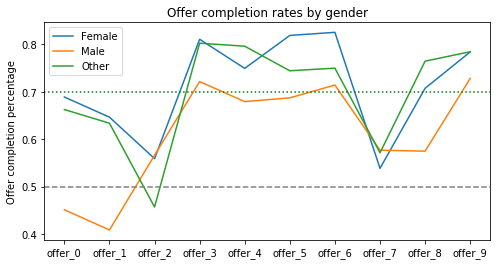

In [264]:
# plot completion rates across the genders
plt.figure(figsize=(8,4));
plt.plot(f_complete_pct, label='Female');
plt.plot(m_complete_pct, label='Male');
plt.plot(o_complete_pct, label='Other');
plt.axhline(y=0.5, color='gray', linestyle='--');
plt.axhline(y=0.7, color='green', linestyle='dotted');
plt.legend();
plt.ylabel('Offer completion percentage');
plt.title('Offer completion rates by gender');


The most successful offers across all genders are offers 3-8 and 9.  The other offer that performs poorly compared to the other offers also not promote through social is the information offer id 2.

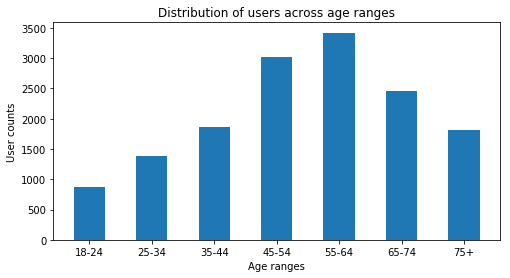

In [266]:
# plot distribution of users across age ranges
plt.figure(figsize=(8,4));
plt.hist(offer_df['age_range'], align='left', bins=range(8), rwidth=.5);
plt.xlabel('Age ranges');
plt.ylabel('User counts');
plt.title('Distribution of users across age ranges');

In [267]:
# Value counts per age range
offer_df.age_range.value_counts()

55-64    3421
45-54    3013
65-74    2457
35-44    1869
75+      1809
25-34    1380
18-24     876
Name: age_range, dtype: int64

In [268]:
# Create set of data for age ranges
df_18to24, offer_completions_18to24, total_received_18to24, complete_pct_18to24 = demographic_completion_info(column='age_range', kind='18-24')
df_25to34, offer_completions_25to34, total_received_25to34, complete_pct_25to34 = demographic_completion_info(column='age_range', kind='25-34')
df_35to44, offer_completions_35to44, total_received_35to44, complete_pct_35to44 = demographic_completion_info(column='age_range', kind='35-44')
df_45to54, offer_completions_45to54, total_received_45to54, complete_pct_45to54 = demographic_completion_info(column='age_range', kind='45-54')
df_55to64, offer_completions_55to64, total_received_55to64, complete_pct_55to64 = demographic_completion_info(column='age_range', kind='55-64')
df_65to74, offer_completions_65to74, total_received_65to74, complete_pct_65to74 = demographic_completion_info(column='age_range', kind='65-74')
df_75plus, offer_completions_75plus, total_received_75plus, complete_pct_75plus = demographic_completion_info(column='age_range', kind='75+')




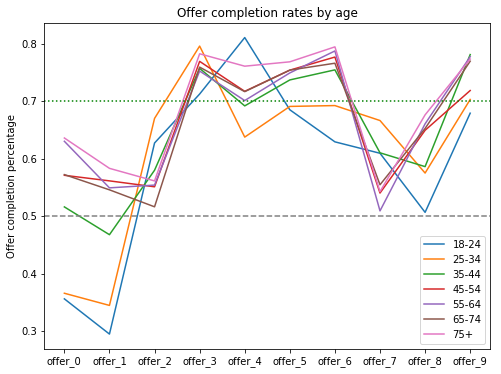

In [269]:
# plot the completion percentage across age ranges
plt.figure(figsize=(8,6));
plt.plot(complete_pct_18to24, label='18-24');
plt.plot(complete_pct_25to34, label='25-34');
plt.plot(complete_pct_35to44, label='35-44');
plt.plot(complete_pct_45to54, label='45-54');
plt.plot(complete_pct_55to64, label='55-64');
plt.plot(complete_pct_65to74, label='65-74');
plt.plot(complete_pct_75plus, label='75+');
plt.axhline(y=0.5, color='gray', linestyle='--');
plt.axhline(y=0.7, color='green', linestyle='dotted');
plt.legend();
plt.ylabel('Offer completion percentage');
plt.title('Offer completion rates by age');

It appears the same trend holds true when looking at the age ranges of the users where offers 3-6 and 9 are the highest performing offers. Age ranges 18-24 and 35-44 have the significantly lowest completion rates across offers 0 and 1. 

In [270]:
# Take a look at the distribution of age range across income ranges
income_range_by_age = offer_df.groupby(['age_range', 'income_range'])['income_range'].count()
income_range_totals = offer_df.groupby('income_range')['income_range'].count()
age_income_dist = round(income_range_by_age/income_range_totals, 2)

In [271]:
age_income_dist

age_range  income_range
18-24      30k-49k         0.12
           49k-64k         0.07
           64k-80k         0.04
25-34      30k-49k         0.17
           49k-64k         0.12
           64k-80k         0.09
35-44      30k-49k         0.16
           49k-64k         0.16
           64k-80k         0.13
           80k-120k        0.06
45-54      30k-49k         0.17
           49k-64k         0.20
           64k-80k         0.21
           80k-120k        0.23
55-64      30k-49k         0.17
           49k-64k         0.20
           64k-80k         0.24
           80k-120k        0.32
65-74      30k-49k         0.13
           49k-64k         0.15
           64k-80k         0.17
           80k-120k        0.22
75+        30k-49k         0.08
           49k-64k         0.10
           64k-80k         0.13
           80k-120k        0.17
Name: income_range, dtype: float64

In [272]:
df_30to49, offer_completions_30to49, total_received_30to49, complete_pct_30to49 = demographic_completion_info(column='income_range', kind='30k-49k')
df_49to64, offer_completions_49to64, total_received_49to64, complete_pct_49to64 = demographic_completion_info(column='income_range', kind='49k-64k')
df_64to80, offer_completions_64to80, total_received_64to80, complete_pct_64to80 = demographic_completion_info(column='income_range', kind='64k-80k')
df_80to120, offer_completions_80to120, total_received_80to120, complete_pct_80to120 = demographic_completion_info(column='income_range', kind='80k-120k')

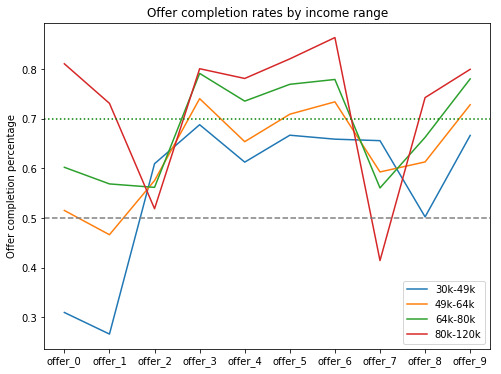

In [273]:
plt.figure(figsize=(8,6));
plt.plot(complete_pct_30to49, label='30k-49k');
plt.plot(complete_pct_49to64, label='49k-64k');
plt.plot(complete_pct_64to80, label='64k-80k');
plt.plot(complete_pct_80to120, label='80k-120k');
plt.axhline(y=0.5, color='gray', linestyle='--');
plt.axhline(y=0.7, color='green', linestyle='dotted');
plt.legend();
plt.ylabel('Offer completion percentage');
plt.title('Offer completion rates by income range');

The highest income users, 80k-120k, have the highest completion rates across all BOGO offers 0, 1, 3, and 8. All discount offers 4, 5, 6, and 9 are fairly high performers across all income demographics.

In [274]:
df.describe()

,time,age,income,days_a_member,user_id,amount,reward_x,difficulty,duration,reward_y,channel_web,channel_email,channel_mobile,channel_social,duration_hours,offer_id_y
count,306534.000000,272762.000000,272762.000000,306534.000000,306534.000000,138953.000000,33579.000000,167581.000000,167581.000000,167581.00000,167581.000000,167581.0,167581.000000,167581.000000,167581.000000,167581.000000
mean,366.382940,53.840696,64337.000755,574.943011,8501.102374,12.777356,4.904137,7.850401,6.610737,4.41991,0.806858,1.0,0.917944,0.656996,158.657700,5.550522
std,200.326314,17.551337,21243.762941,421.482784,4901.913992,30.250529,2.886647,5.048944,2.136130,3.37336,0.394765,0.0,0.274451,0.474714,51.267123,2.885785
min,0.000000,18.000000,30000.000000,0.000000,1.000000,0.050000,2.000000,0.000000,3.000000,0.00000,0.000000,1.0,0.000000,0.000000,72.000000,1.000000
25%,186.000000,41.000000,48000.000000,242.000000,4265.000000,2.780000,2.000000,5.000000,5.000000,2.00000,1.000000,1.0,1.000000,0.000000,120.000000,3.000000
50%,408.000000,55.000000,62000.000000,469.000000,8499.000000,8.890000,5.000000,10.000000,7.000000,5.00000,1.000000,1.0,1.000000,1.000000,168.000000,6.000000
75%,528.000000,66.000000,78000.000000,856.000000,12731.000000,18.070000,5.000000,10.000000,7.000000,5.00000,1.000000,1.0,1.000000,1.000000,168.000000,8.000000
max,714.000000,101.000000,120000.000000,1823.000000,17000.000000,1062.280000,10.000000,20.000000,10.000000,10.00000,1.000000,1.0,1.000000,1.000000,240.000000,10.000000


In [275]:
df_0to242, offer_completions_0to242, total_received_0to242, complete_pct_0to242 = demographic_completion_info(column='days_a_member_range', kind='0-242_days')
df_242to471, offer_completions_242to471, total_received_242to471, complete_pct_242to471 = demographic_completion_info(column='days_a_member_range', kind='242-471_days')
df_471to862, offer_completions_471to862, total_received_471to862, complete_pct_471to862 = demographic_completion_info(column='days_a_member_range', kind='471-862_days')
df_862to1823, offer_completions_862to1823, total_received_862to1823, complete_pct_862to1823 = demographic_completion_info(column='days_a_member_range', kind='862-1823_days')


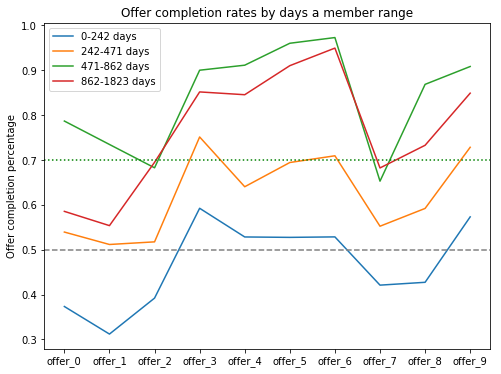

In [276]:
plt.figure(figsize=(8,6));
plt.plot(complete_pct_0to242, label='0-242 days');
plt.plot(complete_pct_242to471, label='242-471 days');
plt.plot(complete_pct_471to862, label='471-862 days');
plt.plot(complete_pct_862to1823, label='862-1823 days');
plt.axhline(y=0.5, color='gray', linestyle='--');
plt.axhline(y=0.7, color='green', linestyle='dotted');
plt.legend();
plt.ylabel('Offer completion percentage');
plt.title('Offer completion rates by days a member range');

This feature has the clearest impact across all offer completion rates. The longer the tenure a user the better the completion rates across all offers.

# Modeling

In [59]:
user_matrix_completions = pd.read_csv('user_offer_completion_matrix_model_labels.csv')

In [60]:
user_matrix_completions.head()

,Unnamed: 0,1,2,3,4,5,6,7,8,9,10
0,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,4,1,-1,-1,1,-1,-1,-1,1,1,-1
2,6,-1,-1,-1,1,-1,-1,1,-1,-1,0
3,9,-1,-1,-1,1,-1,-1,1,-1,1,1
4,13,-1,-1,-1,-1,-1,0,1,-1,-1,-1


In [61]:
user_matrix_completions.rename(columns={"Unnamed: 0": "user_id", '1':'offer_0', '2':'offer_1', '3':'offer_2', '4':'offer_3', '5':'offer_4', '6':'offer_5', '7':'offer_6', '8':'offer_7' , '9':'offer_8', '10':'offer_9'}, inplace=True)
user_matrix_completions.replace(to_replace=-1, value=np.nan, inplace=True)
user_matrix_completions.set_index(keys='user_id', inplace=True)


In [62]:
offer_completions = user_matrix_completions.join(profile.set_index('user_id'), on='user_id')

In [63]:
offer_completions = pd.get_dummies(offer_completions, columns=['gender', 'age_range', 'income_range', 'days_a_member_range'])

In [64]:
offer_completions.drop(['date_member', 'age', 'income', 'id', 'days_a_member'], axis=1, inplace=True)

In [65]:
offer_completions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 2 to 17000
Data columns (total 28 columns):
offer_0                              4996 non-null float64
offer_1                              5332 non-null float64
offer_2                              3053 non-null float64
offer_3                              3090 non-null float64
offer_4                              2004 non-null float64
offer_5                              5325 non-null float64
offer_6                              5377 non-null float64
offer_7                              4989 non-null float64
offer_8                              5272 non-null float64
offer_9                              3055 non-null float64
gender_F                             14825 non-null uint8
gender_M                             14825 non-null uint8
gender_O                             14825 non-null uint8
age_range_18-24                      14825 non-null uint8
age_range_25-34                      14825 non-null uint8
age_range_3

In [66]:
offers_completed_sums = offer_completions.iloc[:, :10].sum().values 
offers_viewed_counts = df_clean.query('event == "offer viewed"').groupby(['offer_id_y'])['user_id'].count().values
offer_completion_pcts = offers_completed_sums / offers_viewed_counts

for i, o in enumerate(offer_list):
        print(o, ": ", round(offer_completion_pcts[i], 2))
    

NameError: name 'offer_list' is not defined

In [67]:
offer_9 = offer_completions.iloc[:,9:]


In [68]:
offer_9.head()

,offer_9,gender_F,gender_M,gender_O,age_range_18-24,age_range_25-34,age_range_35-44,age_range_45-54,age_range_55-64,age_range_65-74,age_range_75+,income_range_30k-49k,income_range_49k-64k,income_range_64k-80k,income_range_80k-120k,days_a_member_range_0-242_days,days_a_member_range_242-471_days,days_a_member_range_471-862_days,days_a_member_range_862-1823_days
user_id,,,,,,,,,,,,,,,,,,,
2,NaN,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
4,NaN,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
6,0.0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0
9,1.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
13,NaN,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0


In [69]:
offer_9_clean = offer_9[~offer_9.offer_9.isnull()]
X = offer_9_clean.iloc[:, 1:]
y = offer_9_clean.iloc[:, 0]

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


## Linear Regression

In [71]:
linclf = LinearRegression().fit(X_train, y_train)

In [72]:
linclf.predict(X_train)
linclf.score(X_train, y_train)

0.11283157599759308

## Logistic Regression

In [73]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)

In [74]:
clf.predict(X_train)
clf.score(X_train, y_train)

0.76941066417212345

In [75]:
lr_pred = clf.predict(X_test)
clf.score(X_test, y_test), f1_score(lr_pred, y_test)


(0.76444929116684845, 0.86363636363636354)

## Random Forest Classifier

In [76]:
rfclf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [77]:
rfclf.predict(X_train)

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [78]:
rfclf.score(X_train, y_train)

0.78484565014031804

In [79]:
pred = rfclf.predict(X_test)

In [80]:
rfclf.score(X_test, y_test)

0.75136314067611776

In [81]:
f1_score(pred, y_test)

0.85214007782101175

In [110]:
feature_importances = pd.DataFrame(rfclf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
days_a_member_range_0-242_days,0.190365
days_a_member_range_471-862_days,0.094457
income_range_30k-49k,0.067799
gender_F,0.060083
income_range_49k-64k,0.052488
income_range_64k-80k,0.049753
days_a_member_range_862-1823_days,0.048308
income_range_80k-120k,0.047606
days_a_member_range_242-471_days,0.046146
age_range_18-24,0.045290


### Initial Model Results:

The feature importance of the model weighs days_a_member as the most important feature in the prediction the accuracy of 78% is decent but let's see if we can improve it. I made ordinal variables that I turned into dummy variables for age, income, and days a member. I am curious to see what happens if I keep those original values, if I normalize them by dividing the value by the max value to keep the range between 0 and 1. 

The random forest classifier had the strongest results of the three models tested. At this point I am using accuracy and F1 score as the measure for model performance but since we are concerned about sending offers to users who may be frustrated to receive said offers its probably best to worry about both precision and recall by using the F1 score.

## Model improvements

In [111]:
modeling_imp_df = pd.read_csv('user_offer_completion_matrix_model_labels.csv')

In [112]:
modeling_imp_df.rename(columns={"Unnamed: 0": "user_id", '1':'offer_0', '2':'offer_1', '3':'offer_2', '4':'offer_3', '5':'offer_4', '6':'offer_5', '7':'offer_6', '8':'offer_7' , '9':'offer_8', '10':'offer_9'}, inplace=True)
modeling_imp_df.replace(to_replace=-1, value=np.nan, inplace=True)
modeling_imp_df.set_index(keys='user_id', inplace=True)
offer_models_df = modeling_imp_df.join(profile.set_index('user_id'), on='user_id')


In [113]:
offer_models_df.head()

,offer_0,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9,age,gender,id,income,date_member,days_a_member,age_range,income_range,days_a_member_range
user_id,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,376,55-64,80k-120k,242-471_days
4,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,443,75+,80k-120k,242-471_days
6,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,0.0,68.0,M,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26,91,65-74,64k-80k,0-242_days
9,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,1.0,65.0,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09,167,65-74,49k-64k,0-242_days
13,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,58.0,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11,257,55-64,49k-64k,242-471_days


In [114]:
offer_models_df.drop(['id', 'age_range', 'income_range', 'date_member', 'days_a_member_range'], axis=1, inplace=True)

In [115]:
offer_models_df = pd.get_dummies(offer_models_df, columns=['gender'])

In [140]:
def model_results(offer_id, df=offer_models_df, classifier=RandomForestClassifier):
    '''
    Inputs:
    offer_id - the offer id you want to make predictions for
    df - the dataframe to use to train the model
    
    Outputs:
    accuracy - accuracy of the model for the specific offer
    f1score - the F1 score for the model for the specific offer
    confusion_matrix_train - the confusion matrix for the model performance for training data
    confusion_matrix_test - the confusion matrix for the model performance for test data
    '''
    offer_list = offer_models_df[offer_id]
    offer_df = offer_models_df.iloc[:,10:]
    offer_df[offer_id] = offer_list
    
    offer_df = offer_df[~offer_df[offer_id].isnull()]
    X = offer_df.iloc[:, :-1]
    y = offer_df.iloc[:, -1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    
    offer_clf = classifier(random_state=42).fit(X_train, y_train)
    
    train_pred = offer_clf.predict(X_train)
    
    test_pred = offer_clf.predict(X_test)
    
    accuracy = offer_clf.score(X_train, y_train)
    
    f1score = f1_score(y_test, test_pred)
    
    # offer_confusion_matrix = confusion_matrix(y_train, train_pred)
    
    offer_confusion_matrix = pd.DataFrame(confusion_matrix(y_train, train_pred), index=['true:yes', 'true:no'], columns=['pred:yes', 'pred:no'])
    
    '''feature_importances = pd.DataFrame(offer_clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)'''
    
    return accuracy, f1score


In [141]:
model_results('offer_1', df=offer_models_df, classifier=LogisticRegression)

(0.57341907824222937, 0.70185449358059915)

Using just the raw features and the dummy variables of gender. We see a massive increase in accuracy but a lowering of the F1 score by ~.03. I think with the increase in accuracy we are fine with a .03 difference in the F1 score. Let's try to make additional improvements to the model. I will also create a function to create offer specific datasets for each offer and to split train and test groups and output the feature importance, confusion matrix, accuracy and F1 score. 

In [142]:
offer_list = ['offer_0', 'offer_1', 'offer_2', 'offer_3', 'offer_4', 
              'offer_5', 'offer_6', 'offer_7', 'offer_8', 'offer_9',]



In [143]:
# print out accuracy and f1 score for each offer model
for o in offer_list:
    print(o,"\n", "Logistic Regression \n", 
          model_results(o, df=offer_models_df, classifier=LogisticRegression), "\n",
          "Random Forest Classifier","\n", model_results(o), "\n")

offer_0 
 Logistic Regression 
 (0.6036602802402059, 0.72391505078485685) 
 Random Forest Classifier 
 (0.98198455819273667, 0.71753846153846157) 

offer_1 
 Logistic Regression 
 (0.57341907824222937, 0.70185449358059915) 
 Random Forest Classifier 
 (0.97775991425509112, 0.67600487210718641) 

offer_2 
 Logistic Regression 
 (0.62845109967243795, 0.69043151969981242) 
 Random Forest Classifier 
 (0.97941038839494621, 0.62650602409638556) 

offer_3 
 Logistic Regression 
 (0.78132223763291719, 0.86450030656039245) 
 Random Forest Classifier 
 (0.98520573277854828, 0.81824370319945539) 

offer_4 
 Logistic Regression 
 (0.7168330955777461, 0.85110470701248797) 
 Random Forest Classifier 
 (0.98858773181169757, 0.81298992161254202) 

offer_5 
 Logistic Regression 
 (0.76522672390662727, 0.86182336182336172) 
 Random Forest Classifier 
 (0.98604775959216528, 0.8352799033427305) 

offer_6 
 Logistic Regression 
 (0.76587828859952167, 0.88218988218988226) 
 Random Forest Classifier 
 (0.99

I don't think I would want to give up the accuracy for a slightly better F1 score using the logistic regression model. Let's try to improve the results of the Random Forest Classifier model. Offers 0,1,2,7 have the lowest fscores, let's see if we can improve the performance for those offers. The logistic regression model also has too many false positives. 

In [144]:
scorer = make_scorer(f1_score)

In [145]:
parameters = { 
    'n_estimators': [3, 5, 10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [146]:
clf = RandomForestClassifier()
rfc_CV = GridSearchCV(estimator=clf, param_grid=parameters)


In [147]:
rfc_CV.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [3, 5, 10, 15, 20], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [148]:
best_clf = rfc_CV.best_estimator_

In [149]:
def best_model_results(offer_id, parameter=parameters, scorer=scorer, df=offer_models_df):
    '''
    Inputs:
    offer_id - the offer id you want to make predictions for
    df - the dataframe to use to train the model
    
    Outputs:
    accuracy - accuracy of the model for the specific offer
    f1score - the F1 score for the model for the specific offer
    confusion_matrix_train - the confusion matrix for the model performance for training data
    confusion_matrix_test - the confusion matrix for the model performance for test data
    '''
    offer_list = offer_models_df[offer_id]
    offer_df = offer_models_df.iloc[:,10:]
    offer_df[offer_id] = offer_list
    
    offer_df = offer_df[~offer_df[offer_id].isnull()]
    X = offer_df.iloc[:, :-1]
    y = offer_df.iloc[:, -1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    
    clf = RandomForestClassifier()
    rfc_CV = GridSearchCV(estimator=clf, param_grid=parameters)
    
    rfc_CV.fit(X_train, y_train)
    
    best_clf = rfc_CV.best_estimator_
    
    train_pred = best_clf.predict(X_train)
    
    test_pred = best_clf.predict(X_test)
    
    accuracy = best_clf.score(X_train, y_train)
    
    f1score = f1_score(y_train, train_pred)
    
    # offer_confusion_matrix = confusion_matrix(y_train, train_pred)
    
    offer_confusion_matrix = pd.DataFrame(confusion_matrix(y_train, train_pred), index=['true:yes', 'true:no'], columns=['pred:yes', 'pred:no'])
    
    feature_importances = pd.DataFrame(best_clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
    
    return accuracy, f1score, feature_importances


In [150]:
best_model_results('offer_1')

(0.75669882100750263, 0.76706003078501794,                importance
 days_a_member    0.385367
 income           0.368488
 age              0.111937
 gender_F         0.065790
 gender_M         0.064831
 gender_O         0.003587)

In [135]:
for o in offer_list:
    print(o,"\n", "Best Random Forest Classifier", best_model_results(o), "\n", 
          o,"\n", "Not GridSearched Random Forest Classifier", model_results(o), "\n")

accuracy: 0.9819845581927367 
 f1score: 0.7175384615384616 
 confusion_matrix: 
           pred:yes  pred:no
true:yes      1511       11
true:no         52     1923
offer_0 
 Best Random Forest Classifier (0.76694309408064054, 0.79751552795031044,                importance
days_a_member    0.400936
income           0.371362
age              0.099147
gender_M         0.068975
gender_F         0.056229
gender_O         0.003351) 
 offer_0 
 Not GridSearched Random Forest Classifier None 

accuracy: 0.9777599142550911 
 f1score: 0.6760048721071864 
 confusion_matrix: 
           pred:yes  pred:no
true:yes      1777       21
true:no         62     1872
offer_1 
 Best Random Forest Classifier (0.75589496248660237, 0.7631920977384975,                importance
days_a_member    0.397134
income           0.333568
age              0.129794
gender_M         0.086405
gender_F         0.049081
gender_O         0.004018) 
 offer_1 
 Not GridSearched Random Forest Classifier None 

accuracy: 0.97941

KeyboardInterrupt: 

In [151]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [152]:
for o in offer_list:
    print(color.BOLD, o,"\n", "Logistic Regression \n", color.END, 
          model_results(o, df=offer_models_df, classifier=LogisticRegression), "\n",
          color.BOLD, "Random Forest Classifier","\n", color.END, model_results(o), "\n",
          color.BOLD, "GridSearch Random Forest Classifier Best results", "\n", color.END, best_model_results(o),)

 offer_0 
 Logistic Regression 
  (0.6036602802402059, 0.72391505078485685) 
  Random Forest Classifier 
  (0.98198455819273667, 0.71753846153846157) 
  GridSearch Random Forest Classifier Best results 
  (0.75207320560480406, 0.78534290666006434,                importance
days_a_member    0.457730
income           0.323266
gender_M         0.084154
age              0.080143
gender_F         0.051251
gender_O         0.003455)
 offer_1 
 Logistic Regression 
  (0.57341907824222937, 0.70185449358059915) 
  Random Forest Classifier 
  (0.97775991425509112, 0.67600487210718641) 
  GridSearch Random Forest Classifier Best results 
  (0.74651661307609862, 0.75718685831622168,                importance
days_a_member    0.409733
income           0.329487
gender_F         0.112514
age              0.087740
gender_M         0.056794
gender_O         0.003732)
 offer_2 
 Logistic Regression 
  (0.62845109967243795, 0.69043151969981242) 
  Random Forest Classifier 
  (0.97941038839494621, 0.62650

# Conclusion

I was surprised to find that the most important feature to determine whether an offer would be completed was the number of days they were a member. It was pretty clear from the plots as well as the feature importance of the models that this was the case. 

Why was I surprised? I suppose I presumed that specific demographics, age or income, would be the more relevant measures due to the behaviors of those generations or due to wealth. But I suppose the longer you use the starbucks membership the more you interact with it and patronize starbucks.

Although the initial random forest classifier had a high level of accuracy it suffered a bit from precision and recall. I tracked the F1 score a measure that incorporates both precision and recall to ensure that I was considering both when modeling which users will complete an offer. I decided to create a unique model for each offer as each offer had unique characteristics which I didn't want to bundle together into the 3 types of offerings: BOGO, discount, and informational. 

Offer 2 and 7 had the lowest performing models which were the two informational offers. I did decide to only count a single offer completion even if there were multiple purchases after viewing an informational offer. I didn't specify an amount needed to be spent for the informational offers as I was told that any transaction after viewing the offer was influenced by the informational offer. 


